In [1]:
#    - Read/write spatial data from/to file.------------------- Done
#    - Reproject data (if needed).-----------------------------Done
#    - Spatial queries. --------------------------------------Done

#    - Geoprocessing operations (one or several): 
#     intersection,----------------Done 
#     union, 
#     difference,-----------------DOne 
#     dissolve.------------done


#    - Create a static map (map, legend, basemap from external source) and save it as a figure. 
#    - Create an interactive map presenting the result (information or data) obtained.
#    - Use raster data, e.g. for visualization (if needed).
# Other functionalities, related to spatial and non-spatial data processing, may be created upon the need of the project.





#I would like to inform you that, I will work on a dataset Land Surface Temparature Analysis(LST) in Phnom Penh, in Cambodia
# I have collected the area borders for the area, and I will download the multiband sentinel 2 data from USGS to calculate 
#the LST for the area. And, before that, I plan to collect some more data from OSM Archive about different land uses for the
#area.Using those I will try to generate some static plot. At the end, I want show the LST layer as an interactive map using
#leaflet based libraries.


In [2]:
# Import the required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as mat_pyplt
from matplotlib.colors import ListedColormap
import folium
import contextily as ctx
import numpy as np
import rasterio
from rasterio.plot import show_hist


Text(0.5, 1.0, 'Cambodia Provinces')

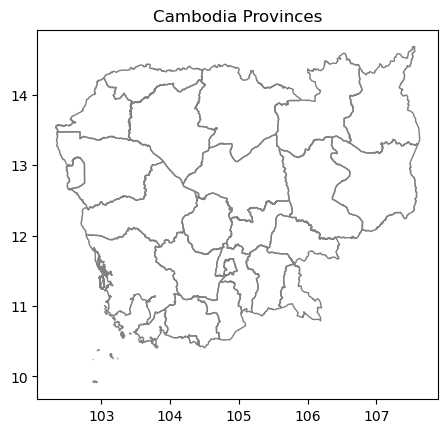

In [3]:
# cambodia_provinces = gpd.read_file("./Data/KHM_adm/cambodia_provinces_clipped/cambodia_provinces_clipped.shp")
cambodia_provinces = gpd.read_file("./Data/Inputs/KHM_adm/KHM_adm1.shp")
cambodia_provinces.plot(color='None', edgecolor='Grey').set_title('Cambodia Provinces')

Text(0.5, 1.0, 'Area of Interest: Phnom Penh, Cambodia')

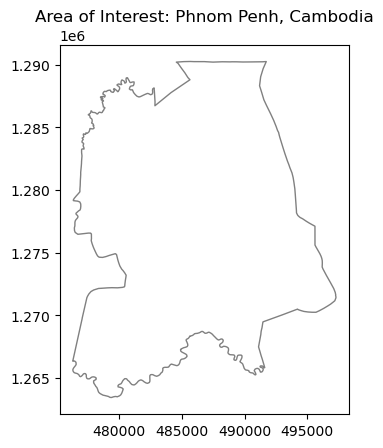

In [4]:
# cambodia_border = gpd.read_file("./Data/KHM_adm/KHM_adm0.shp")
aoi_shape = gpd.read_file('./Data/Inputs/Aoi/PhnomPenh.shp')
aoi_shape.plot(color="None", edgecolor='Grey').set_title("Area of Interest: Phnom Penh, Cambodia")

In [5]:
cambodia_provinces_reprojected = cambodia_provinces.to_crs(aoi_shape.crs)

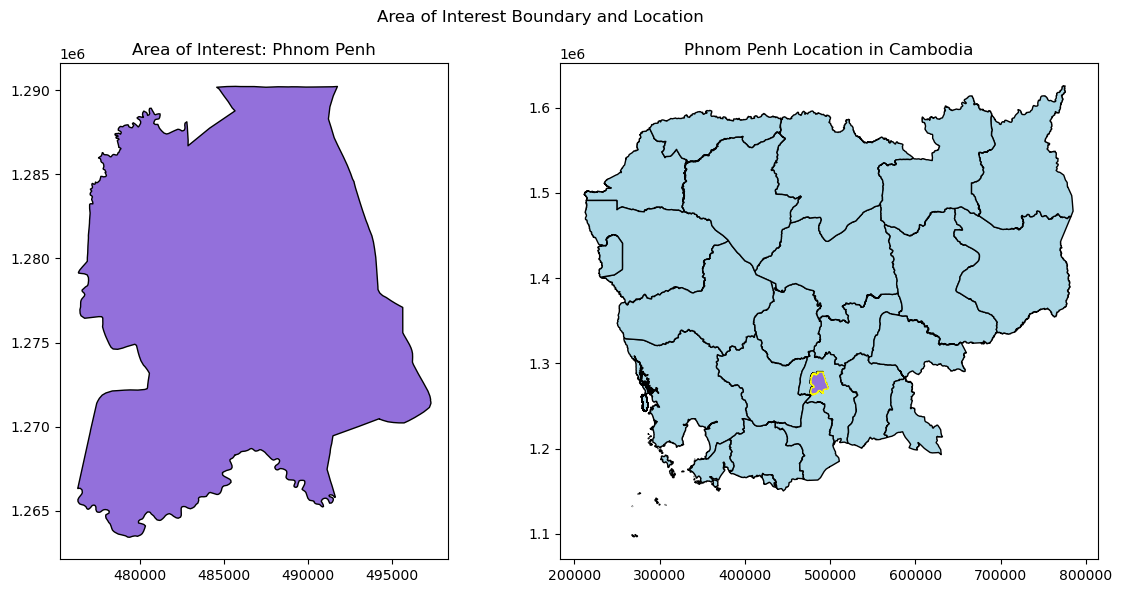

In [6]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = mat_pyplt.subplots(1, 2, figsize=(12, 6))

# Plot the AOI shape in the first subplot
aoi_shape.plot(ax=ax1, facecolor='mediumpurple', edgecolor='Black')
ax1.set_title("Area of Interest: Phnom Penh")

# Plot the provinces and AOI shape in the second subplot
cambodia_provinces_reprojected.plot(ax=ax2, facecolor='lightblue', edgecolor='Black')
aoi_shape.plot(ax=ax2, facecolor='mediumpurple', edgecolor='Yellow')
ax2.set_title("Phnom Penh Location in Cambodia")


# Add a title for the whole plot
mat_pyplt.suptitle("Area of Interest Boundary and Location")
# Adjust the spacing between subplots
mat_pyplt.tight_layout()
# Display the plot
mat_pyplt.show()
# Save the plot as an image file
fig.savefig("./Data/Outputs/Area_of_Interest_Boundary_and_Location.png", #Saving Location
            dpi=300,  # dots per inch
            bbox_inches='tight',  # Adjust the bounding box to include the entire plot
            format='jpg',  # Specify the file format e.g., 'png', 'jpg', 'svg'
           )

In [7]:
# Reading the geopackage file with Khum(Level 3 Administrative Unit) information
cambodia_khums = gpd.read_file("./Data/Inputs/KHM_adm/KHM_adm3.gpkg", layer = 'KHM_adm3')
# countries_gdf = geopandas.read_file("package.gpkg", layer='countries')
unique_khum_names = cambodia_khums.NAME_3.unique()
cambodia_total_khums = len(cambodia_khums.NAME_3.unique())

print("Total Number of Khums in Cambodia:",cambodia_total_khums)

print("Finding Khums only in Area of Interest")
# Ensure that the CRS matches, if not - raise an AssertionError
if aoi_shape.crs != cambodia_khums.crs:
    print('CRS Differs Between Layers. Trying to reproject...')
    
    try:
        cambodia_khums_reproj = cambodia_khums.to_crs(crs=aoi_shape.crs, epsg=None, inplace=False)
        print('Both layers converted to:',aoi_shape.crs)
    except:
        print('Reprojection Failed! Please Debug The Code')
aoi_khums = cambodia_khums_reproj.overlay(aoi_shape, how = 'intersection')

aoi_khums.to_file('./Data/Outputs/Khums_in_Area_of_Interest.gpkg', driver='GPKG', layer='Khums_in_Area_of_Interest')  

aoi_khums_count = len(aoi_khums.NAME_3.unique())

print("Total Khums "+str(aoi_khums_count)+" Found in Area of Interest")

Total Number of Khums in Cambodia: 1387
Finding Khums only in Area of Interest
CRS Differs Between Layers. Trying to reproject...
Both layers converted to: EPSG:32648
Total Khums 104 Found in Area of Interest


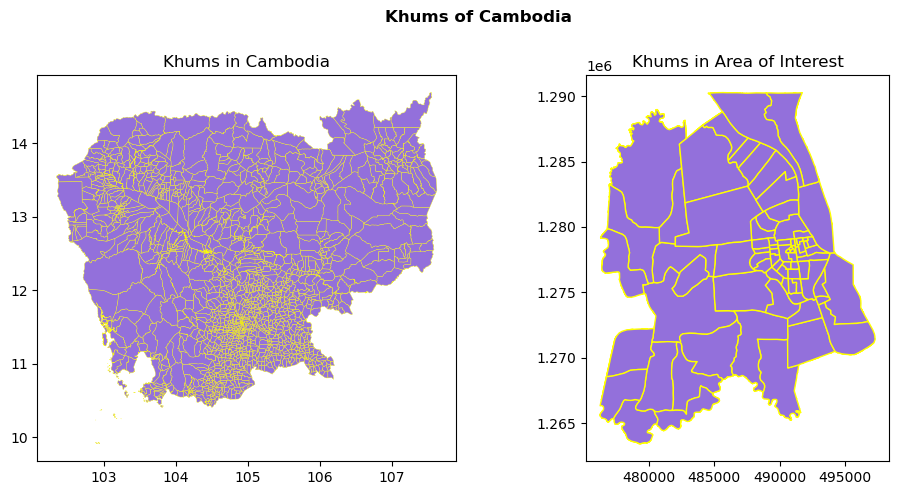

In [8]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = mat_pyplt.subplots(1, 2, figsize=(10, 5))

# Plot the cambodia_districts in the first subplot
cambodia_khums.plot(ax=ax1,facecolor= 'mediumpurple', edgecolor='yellow', linewidth=0.25)
ax1.set_title('Khums in Cambodia')

# Plot the aoi_khums in the second subplot
aoi_khums.plot(ax=ax2, facecolor='mediumpurple', edgecolor='yellow')
ax2.set_title('Khums in Area of Interest')

# Adjust the spacing between subplots
mat_pyplt.tight_layout()

# Add a title for the whole plot
mat_pyplt.suptitle("Khums of Cambodia", fontweight='bold')
mat_pyplt.subplots_adjust(top=0.85)

# Display the plot
mat_pyplt.show()
fig.savefig("./Data/Outputs/Khums_in_Area_of_Interest.png", #Saving Location
            dpi=300,  # dots per inch
            bbox_inches='tight',  # Adjust the bounding box to include the entire plot
            format='png',  # Specify the file format e.g., 'png', 'jpg', 'svg'
)


In [9]:
# Find the Khums only on Phnom Phn Main Municipality
khums_in_phnom_munic =  aoi_khums[aoi_khums['NAME_2']=='Phnom Penh']
khums_outside_phnm_munic = gpd.overlay(aoi_khums, khums_in_phnom_munic, how = 'difference')

khums_in_phnom_munic.to_file('./Data/Outputs/khums_in_phnom_munic.geojson', driver='GeoJSON')
khums_in_phnom_munic.to_file('./Data/Outputs/khums_outside_phnom_munic.shp')

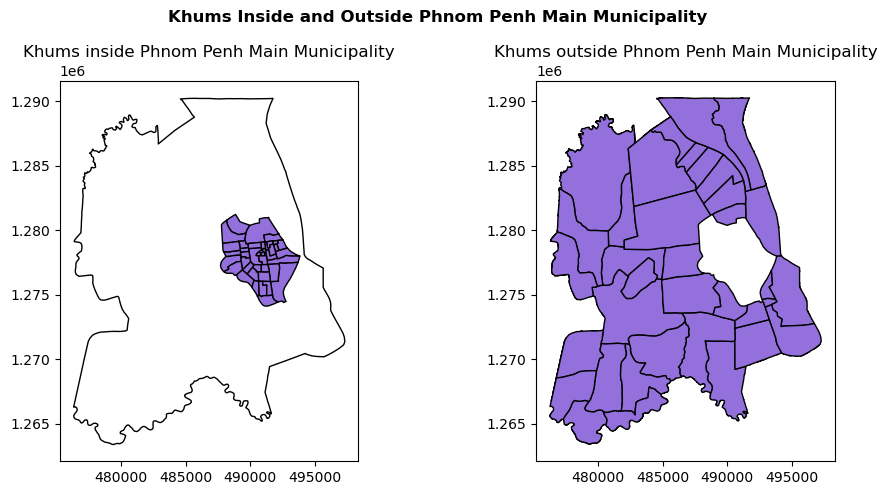

In [10]:
# Create subplots with one row and two columns
fig, (ax1, ax2) = mat_pyplt.subplots(1, 2, figsize=(10, 5))

# Plot Khums inside Phnom Penh Main Municipality
ax1.set_title('Khums inside Phnom Penh Main Municipality')
aoi_shape.plot(ax=ax1, facecolor='White', edgecolor='Black')
khums_in_phnom_munic.plot(ax=ax1, facecolor='mediumpurple', edgecolor='Black')

# Plot Khums outside Phnom Penh Main Municipality
ax2.set_title('Khums outside Phnom Penh Main Municipality')
khums_outside_phnm_munic.plot(ax=ax2, facecolor='mediumpurple', edgecolor='Black')

# Adjust spacing between subplots and main title
mat_pyplt.subplots_adjust(top=0.85)

# Add a title for the whole plot
mat_pyplt.suptitle("Khums Inside and Outside Phnom Penh Main Municipality",fontweight='bold')

# Display the plots
mat_pyplt.tight_layout()
mat_pyplt.show()
fig.savefig("./Data/Outputs/Khums_Inside_and_Outside_Phnom_Penh_Main_Municipality.png", #Saving Location
            dpi=300,  # dots per inch
            bbox_inches='tight',  # Adjust the bounding box to include the entire plot
            format='png',  # Specify the file format e.g., 'png', 'jpg', 'svg'
)

In [11]:
# Now that we have all the khums inside the Phnom Penh main Municipality, we can get the border of municipality by 
# clipping total border of phnom penh state by khum data frame

phnom_penh_municipality_border = gpd.clip(aoi_shape, khums_in_phnom_munic, keep_geom_type=False)
khums_in_phnom_munic.to_file('./Data/Outputs/phnom_penh_municipality_border.shp')


In [12]:
phnom_penh_munc_landuse = gpd.read_file("./Data/Inputs/inside_phnom_penh_land_use.geojson", driver='GeoJSON')
# first let's check the column names
print('The dataframe has the following columns:', phnom_penh_munc_landuse.columns.values)
print('The dataframe total rows:', phnom_penh_munc_landuse.shape[0])

# C_L2 columns hold the land use info. Let's check the unique values and their counts in C_L2
print('\nCounts of rows for each land use type:\n', phnom_penh_munc_landuse['C_L2'].value_counts())

# Combine the polygons of the same land use type
dissolved_phnom_penh_munc_landuse = phnom_penh_munc_landuse.dissolve(by="C_L2")
dissolved_phnom_penh_munc_landuse.reset_index(inplace=True)

# Print the counts of rows for each land use type after dissolving
print('\nCounts of rows for each land use type after dissolving:\n', dissolved_phnom_penh_munc_landuse['C_L2'].value_counts())




# We can not understand which code stands for what class, lets add the names for each class number
class_names = pd.read_csv('./Data/Inputs/CL2_NL2_Names.csv')
print(class_names)

# Adding the N_L2 values from class_names file to the dissolved class files 
dissolved_phnom_penh_munc_landuse = dissolved_phnom_penh_munc_landuse.merge(class_names, on = 'C_L2')
print('\n\n\n',dissolved_phnom_penh_munc_landuse.head(2))

The dataframe has the following columns: ['C_L2' 'AREA' 'ID' 'geometry']
The dataframe total rows: 2154

Counts of rows for each land use type:
 11000    1272
12000     597
13000     132
14000     112
51000      32
32000       8
31000       1
Name: C_L2, dtype: int64

Counts of rows for each land use type after dissolving:
 11000    1
12000    1
13000    1
14000    1
31000    1
32000    1
51000    1
Name: C_L2, dtype: int64
    C_L2                                               N_L2
0  11000                                       Urban Fabric
1  12000  Industrial, Commercial, Public, Military, Priv...
2  13000                  Mine, Dump and Construction Sites
3  32000  Other Natural and Semi-natural Areas (Savannah...
4  51000                                       Inland Water
5  31000                                             Forest
6  20000                                  Agricultural Area
7  14000        Artificial non-agricultural vegetated areas
8  33000                        

In [13]:
# Right now the landuse data does not include which in which khum is the polygon located
# We want to add khum info to the polygons by doing spatial join

# CRS of both dataframes should be same
cambodia_khums_reprojected = cambodia_khums.to_crs(dissolved_phnom_penh_munc_landuse.crs)

dissolved_phnom_penh_munc_landuse_with_khum = dissolved_phnom_penh_munc_landuse.sjoin(cambodia_khums_reprojected, how="left")


# however, we dont need all columns
columns_to_drop = ["index_right", "ID_0", "ISO", "NAME_0", "ID_1", "NAME_1", "ID_2", "ID_3","TYPE_3", "ENGTYPE_3", "NL_NAME_3", "VARNAME_3" ]

# removing the unnecessary columns 
dissolved_phnom_penh_munc_landuse_with_khum = dissolved_phnom_penh_munc_landuse_with_khum.drop(columns=columns_to_drop)

# the names in N_L2 column are lengthy, We will set shorter names

dissolved_phnom_penh_munc_landuse_with_khum.reset_index
dissolved_phnom_penh_munc_landuse_with_khum

,C_L2,geometry,AREA,ID,N_L2,NAME_2,NAME_3
0,11000,"MULTIPOLYGON (((487911.176 1276856.838, 487914...",1.268569e+04,2803,Urban Fabric,Mean Chey,Chak Angrae Leu
0,11000,"MULTIPOLYGON (((487911.176 1276856.838, 487914...",1.268569e+04,2803,Urban Fabric,Mean Chey,Boeng Tumpun
0,11000,"MULTIPOLYGON (((487911.176 1276856.838, 487914...",1.268569e+04,2803,Urban Fabric,Phnom Penh,n.a. ( 1051)
0,11000,"MULTIPOLYGON (((487911.176 1276856.838, 487914...",1.268569e+04,2803,Urban Fabric,Mean Chey,Stueng Mean Chey
0,11000,"MULTIPOLYGON (((487911.176 1276856.838, 487914...",1.268569e+04,2803,Urban Fabric,Phnom Penh,n.a. ( 1044)
...,...,...,...,...,...,...,...
6,51000,"MULTIPOLYGON (((491187.060 1274435.217, 491184...",1.093594e+07,4856,Inland Water,Ruessei Kaev,Chrouy Changva
6,51000,"MULTIPOLYGON (((491187.060 1274435.217, 491184...",1.093594e+07,4856,Inland Water,Phnom Penh,n.a. ( 986)
6,51000,"MULTIPOLYGON (((491187.060 1274435.217, 491184...",1.093594e+07,4856,Inland Water,Phnom Penh,n.a. ( 979)
6,51000,"MULTIPOLYGON (((491187.060 1274435.217, 491184...",1.093594e+07,4856,Inland Water,Phnom Penh,n.a. ( 978)


In [14]:
# dissolved_phnom_penh_munc_landuse

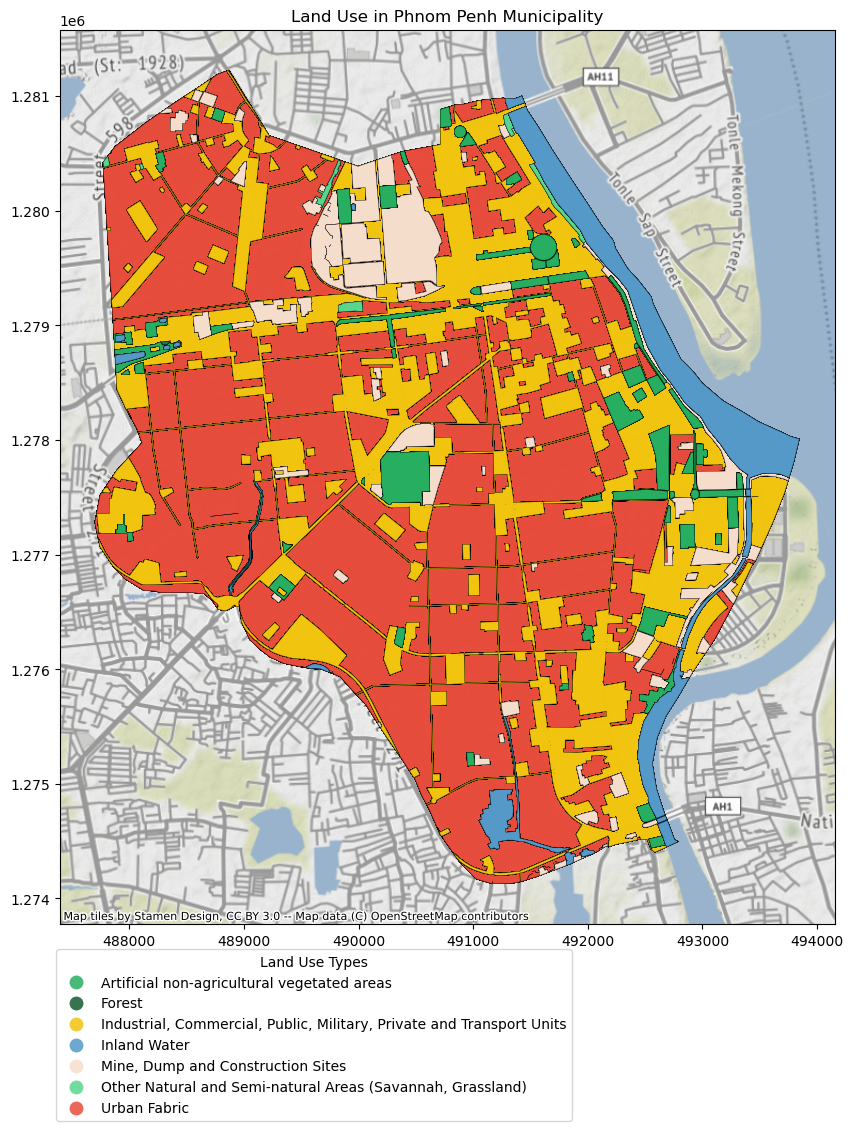

In [15]:
# Define the desired colors for each land use class
colors = ['#27AE60', '#145A32', '#F1C40F', '#5499C7', '#F6DDCC','#58D68D' , '#E74C3C']

# Create a custom color map with the specified colors
color_map = ListedColormap(colors)

# Plot phnom_penh_munc_landuse with customized colors for each unique value in the N_L2 column
fig, ax = mat_pyplt.subplots(figsize=(10, 14))
dissolved_phnom_penh_munc_landuse_with_khum.plot(ax=ax, column='N_L2', cmap=color_map, edgecolor='black', linewidth=0.25, alpha=0.85, legend=True)

# Add a basemap from OpenStreetMap
ctx.add_basemap(ax, crs=dissolved_phnom_penh_munc_landuse_with_khum.crs.to_string())

# Set the title
ax.set_title('Land Use in Phnom Penh Municipality')

# Move the legend box outside of the main frame
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.67, -0.02))
legend.set_title('Land Use Types')

# Show the plot
mat_pyplt.show()

# Save the figure with adjusted padding
fig.savefig("./Data/Outputs/Land_Use_in_Phnom_Penh_Municipality.png", bbox_inches='tight')


In [16]:
# Create the Folium map
m = folium.Map([11.55, 104.9], zoom_start=11)

# Define the desired colors for each class
colors = {
    11000: 'DarkRed',
    12000: 'Red',
    13000: 'Yellow',
    14000: 'Green',
    51000: 'Blue',
    32000: 'darkpurple',
    31000: 'darkgreen'
}
# Add a GeoJSON layer for aoi_shape with a name
folium.GeoJson(aoi_shape, name="AOI Shape", tooltip='Phnom Penh Boundary').add_to(m)
# Add a GeoJSON layer for dissolved_phnom_penh_munc_landuse with customized styling and a name
folium.GeoJson(dissolved_phnom_penh_munc_landuse_with_khum, 
               style_function=lambda x: {
                   "fillColor": colors.get(x['properties']['C_L2'], 'gray'),
                   "color": "black",
                   "weight": 0.5,
                   "fillOpacity": 0.7
               },
               name="Land Use",
               tooltip=folium.GeoJsonTooltip(fields=['N_L2'], labels=False, sticky=True)).add_to(m)



# Adding the layer control
folium.LayerControl().add_to(m)

# Display the map
m
# Save the map as HTML
m.save("map.html")

In [17]:
bands_path = './Data/Inputs/LC09_L2SP_126052_20230622_20230624_02_T1'

b1 = rasterio.open(bands_path+'/B1.tif') # ultra blue, coastal aerosol
b2 = rasterio.open(bands_path+'/B2.tif') # blue
b3 = rasterio.open(bands_path+'/B3.tif') # green
b4 = rasterio.open(bands_path+'/B4.tif') # red
b5 = rasterio.open(bands_path+'/B5.tif') # near infrared
b6 = rasterio.open(bands_path+'/B6.tif') # shortwave infrared 1
b7 = rasterio.open(bands_path+'/B7.tif') # shortwave infrared 2
b10 = rasterio.open(bands_path+'/B10.tif')

all_bands = [b1,b2,b3,b4,b5,b6,b7,b10]

In [18]:
bands_data = [] # holds the bands main data array
stats = [] # holds the band statistics

# Checking the meta information
for band in all_bands:
    
        
    band_data = band.read(1)
    bands_data.append(band_data)
    
    # calculate the stats
    band_stats = {'min': band_data.min(),
                  'mean': band_data.mean(),
                  'median': np.median(band_data),
                  'max': band_data.max()
                 }
    stats.append(band_stats)
    
    
    print("\nName:", band.name)
    
    # Check type of the variable 'raster'
    print("\tType:",type(band))
    # Projection
    print('\tProjection:',band.crs)

    # Dimensions
    print("\tWidth:", band.width, "Height:",band.height)

    # Number of bands
    print("\tCount of bands:", band.count)

    # Bounds of the file
    print("\tBounds of raster:", band.bounds)

    # Driver (data format)
    print("\tRaster File Type:",band.driver)

    # No data values for all channels
    print("\tNo Data Values: ", band.nodatavals)

    print("\tBand Statistic:",band_stats)
    

    # Affine transform (how raster is scaled, rotated, skewed, and/or translated)
    print("\tAffine:",band.transform)
    



Name: ./Data/Inputs/LC09_L2SP_126052_20230622_20230624_02_T1/B1.tif
	Type: <class 'rasterio.io.DatasetReader'>
	Projection: EPSG:32648
	Width: 699 Height: 893
	Count of bands: 1
	Bounds of raster: BoundingBox(left=476295.0, bottom=1263465.0, right=497265.0, top=1290255.0)
	Raster File Type: GTiff
	No Data Values:  (0.0,)
	Band Statistic: {'min': 0, 'mean': 9219.181724972645, 'median': 8944.0, 'max': 45270}
	Affine: | 30.00, 0.00, 476295.00|
| 0.00,-30.00, 1290255.00|
| 0.00, 0.00, 1.00|

Name: ./Data/Inputs/LC09_L2SP_126052_20230622_20230624_02_T1/B2.tif
	Type: <class 'rasterio.io.DatasetReader'>
	Projection: EPSG:32648
	Width: 699 Height: 893
	Count of bands: 1
	Bounds of raster: BoundingBox(left=476295.0, bottom=1263465.0, right=497265.0, top=1290255.0)
	Raster File Type: GTiff
	No Data Values:  (0.0,)
	Band Statistic: {'min': 0, 'mean': 9922.33270533653, 'median': 9605.0, 'max': 48290}
	Affine: | 30.00, 0.00, 476295.00|
| 0.00,-30.00, 1290255.00|
| 0.00, 0.00, 1.00|

Name: ./Data/I

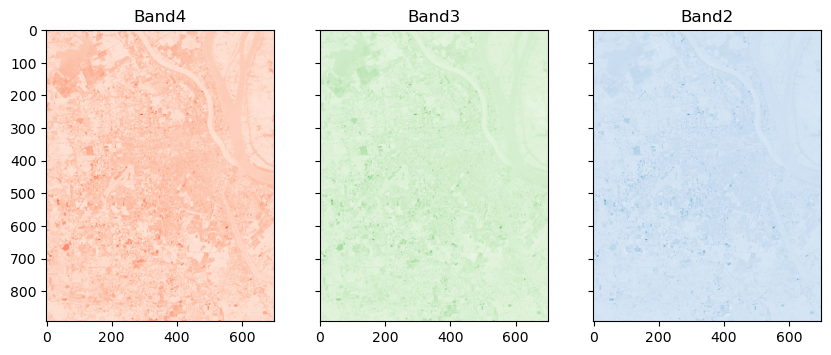

In [19]:
fig, (ax1, ax2, ax3) = mat_pyplt.subplots(ncols=3, nrows=1, figsize=(10, 6), sharey=True)

# Plot red, green, and blue bands
ax1.imshow(bands_data[3], cmap='Reds')
ax2.imshow(bands_data[2], cmap='Greens')
ax3.imshow(bands_data[1], cmap='Blues')

# Add titles
ax1.set_title("Band4")
ax2.set_title("Band3")
ax3.set_title("Band2")

mat_pyplt.show()

# Save the figure with adjusted padding
fig.savefig("./Data/Outputs/Individual Bands (B4, B3, B2).png", bbox_inches='tight')


In [20]:
# We are interested to calculate lst only for Phom Penh municipality. So lets clip the bands


# Rasterio expects the coordinates of the boundary points of mask layer in json format
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

boundary = getFeatures(phnom_penh_municipality_border)

# Now clipping the raster
from rasterio.mask import mask

clipped_bands_data = []
clipped_bands_transforms = []

for band in all_bands:
    clipped_band, clipped_band_transform = mask(band, shapes=boundary, crop=True)
    clipped_bands_data.append(clipped_band)
    clipped_bands_transforms.append(clipped_band_transform)

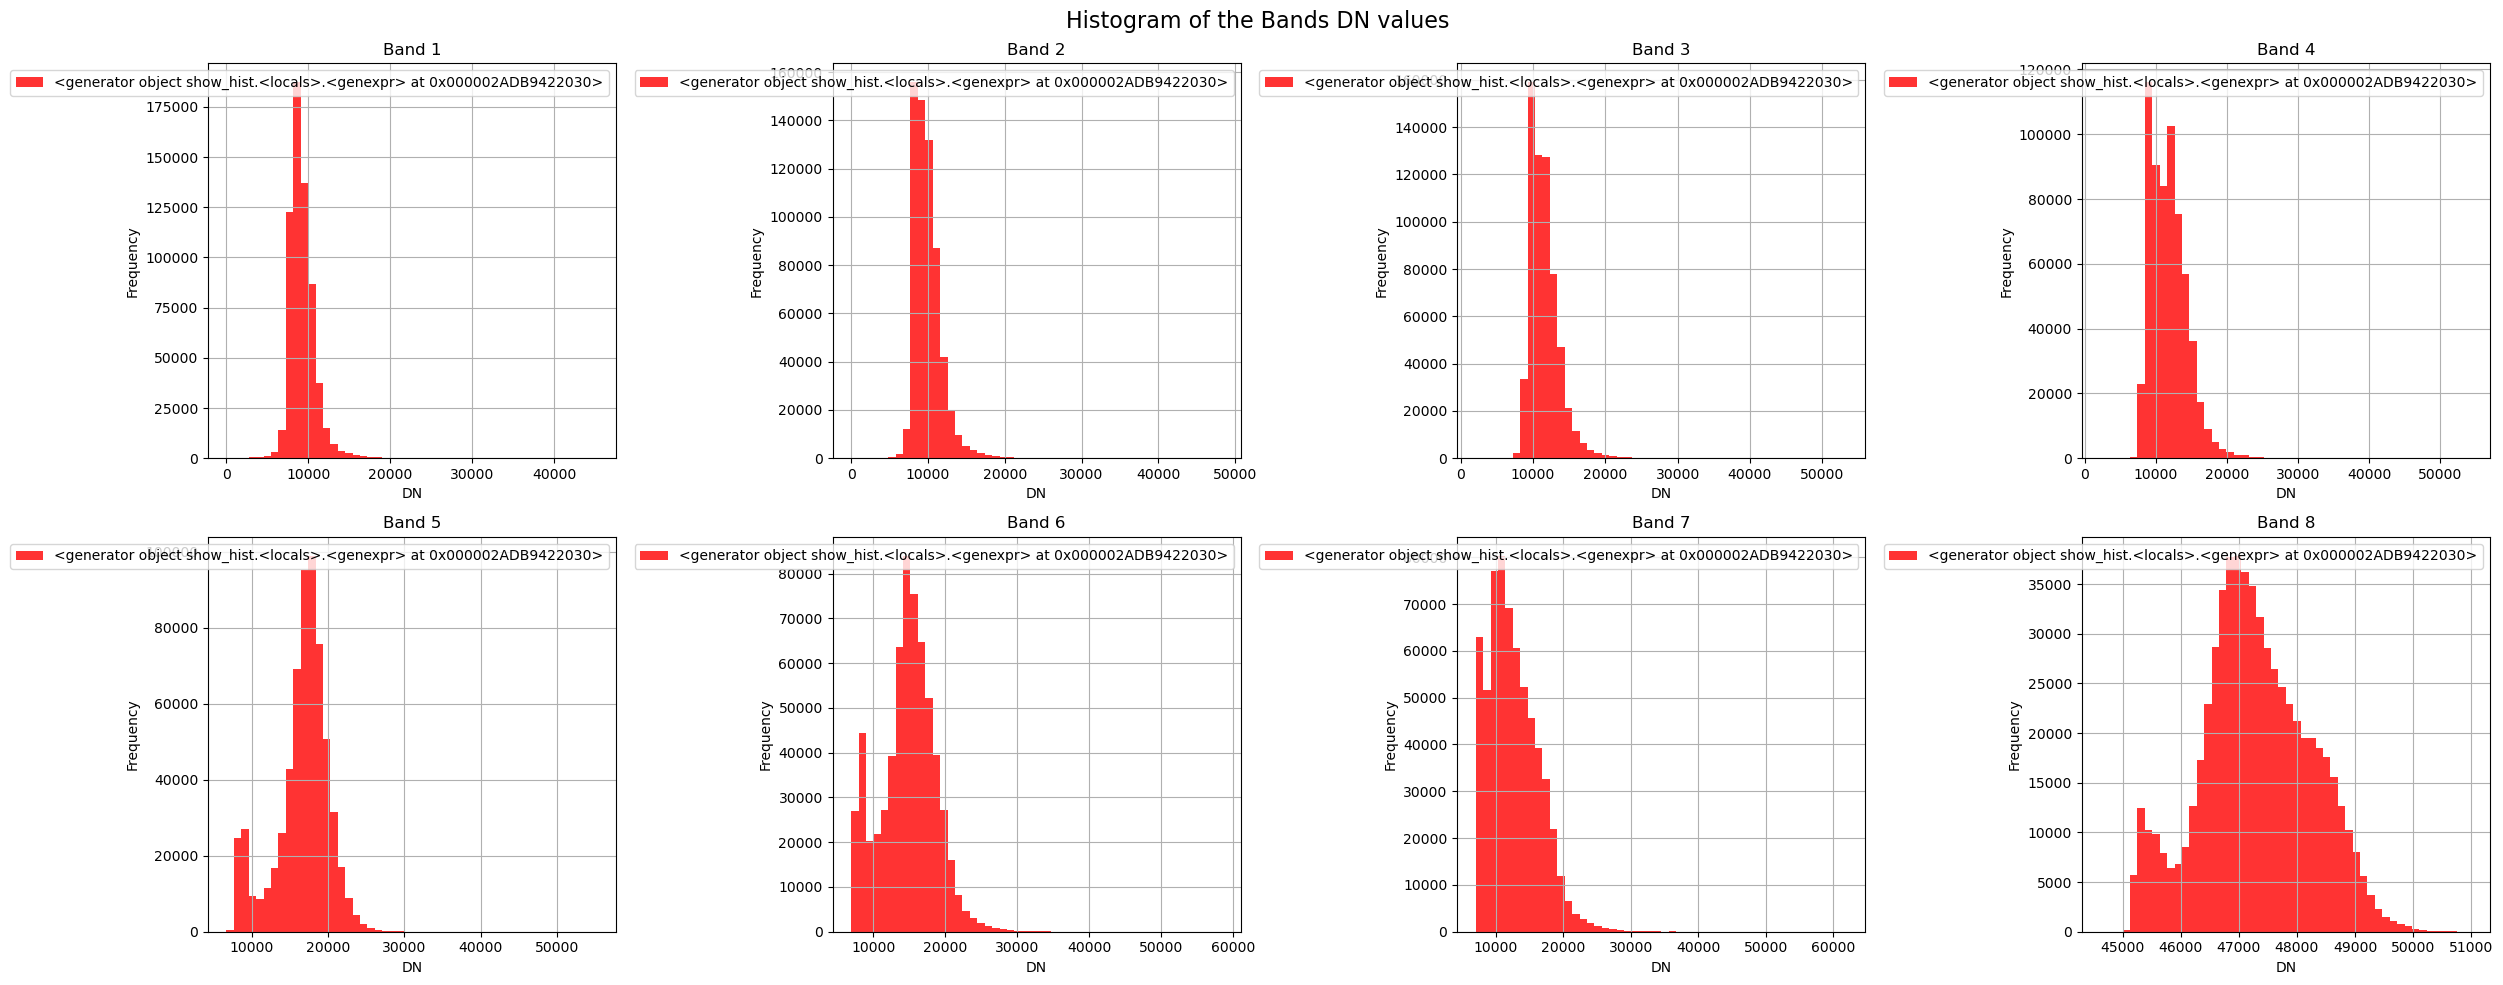

In [21]:
num_bands = len(all_bands)
num_rows = (num_bands + 3) // 4
fig, axs = mat_pyplt.subplots(num_rows, 4, figsize=(25, 5 * num_rows))

for idx, band in enumerate(all_bands):
    rowidx = idx // 4
    colidx = idx % 4

    ax = axs[rowidx, colidx]

    # Plot the histogram of the band
    show_hist(band, ax=ax, bins=50, lw=0.0, stacked=False, alpha=0.8)

    # Set the band title
    ax.set_title(f"Band {idx + 1}")

# Hide any unused subplots
if num_bands < num_rows * 4:
    for i in range(num_bands, num_rows * 4):
        axs.flatten()[i].axis('off')

# Add title
mat_pyplt.suptitle('Histogram of the Bands DN values',  fontsize=16)

# Adjust subplot spacing
mat_pyplt.tight_layout()

mat_pyplt.show()

# Saving the figure with adjusted padding
fig.savefig("./Data/Outputs/Bands_Histograms.png", bbox_inches='tight')


In [22]:
# The values are spread in a big range. we will normalize the bands
def normalize(array):
    """Normalizes numpy arrays into scale 0.0-1.0"""
    """Credit: Dr. Tracz class lecture codes"""
    
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

bands_data_normalized = []

for index, band in enumerate(bands_data):
    # Normalize the bands
    bandN = normalize(band)
    bands_data_normalized.append(bandN) # saving the normalized band to the normalized bands list

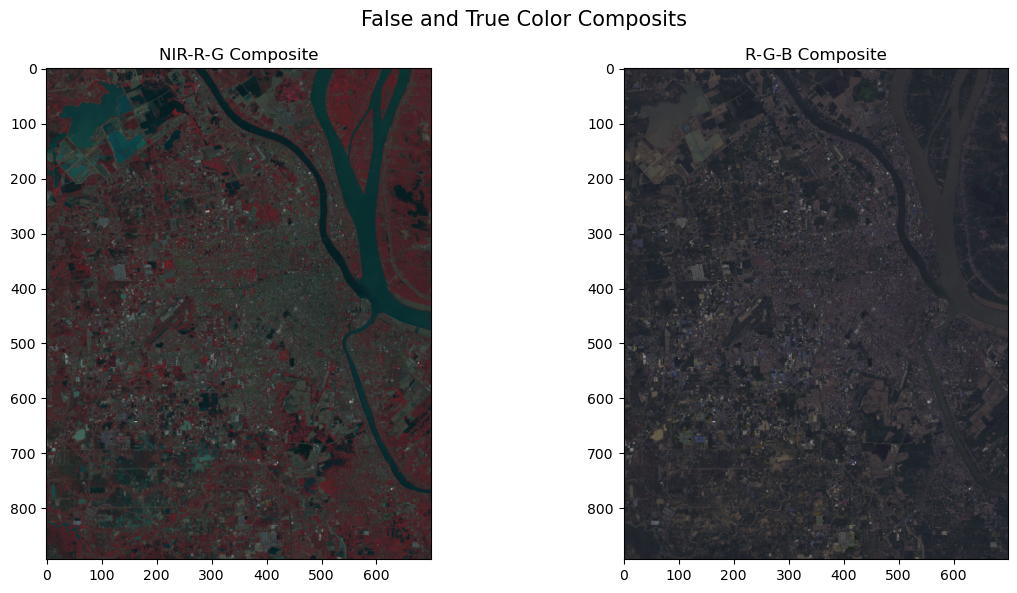

In [23]:
# Creating false color composite of nir, r, g bands
nrg = np.dstack((bands_data_normalized[4], bands_data_normalized[3], bands_data_normalized[2]))

# Creating false color composite of nir, r, g bands
rgb = np.dstack((bands_data_normalized[3], bands_data_normalized[2], bands_data_normalized[1]))

fig, axs = mat_pyplt.subplots(1, 2, figsize=(12, 6))

# Plot the first image (nrg) in the first subplot
axs[0].imshow(nrg)
axs[0].set_title('NIR-R-G Composite')

# Plot the second image (rgb) in the second subplot
axs[1].imshow(rgb)
axs[1].set_title('R-G-B Composite')

# Adding title
mat_pyplt.suptitle('False and True Color Composits',  fontsize=15)

# Adjusting spacing between subplots
mat_pyplt.tight_layout()

# Display the plot
mat_pyplt.show()

# Saving the figure with adjusted padding
fig.savefig("./Data/Outputs/False_and_True_Color_Composits.png", bbox_inches='tight')

In [24]:
meta = b4.meta
meta.update(count=3)
meta.update(driver='GTiff')
meta.update(dtype='float32')

# Defining the destination file for nrg
nrg_data = (bands_data_normalized[4], bands_data_normalized[3], bands_data_normalized[2])
nrg_composite_path = './Data/Outputs/nrg_composite.tif'
dst_nrg = rasterio.open(nrg_composite_path, 'w', **meta)

# Writing all bands to destination file
for index, band in enumerate(nrg_data):
    dst_nrg.write(band, index+1)

dst_nrg.close()

# Defining the destination file for rgb
rgb_data = (bands_data_normalized[3], bands_data_normalized[2], bands_data_normalized[1])
rgb_composite_path = './Data/Outputs/rgb_composite.tif'
dst_rgb = rasterio.open(rgb_composite_path, 'w', **meta)

# Writing all bands to destination file
for index, band in enumerate(rgb_data):
    dst_rgb.write(band, index+1)

dst_rgb.close()

In [25]:
# Now calculate lst for the clipped area of Phnom Penh Municipality
# Change the reaction of numpy in order to not complain about dividing with zero values using np
np.seterr(divide='ignore', invalid='ignore')

#Picking the required bands
nir_data = bands_data_normalized[4]
red_data = bands_data_normalized[3]
thermal_data = bands_data_normalized[7]


# Compute the NDVI for clipped images/aoi
ndvi = (nir_data - red_data) /( nir_data + red_data)
min_ndvi = np.min(ndvi)
max_ndvi = np.max(ndvi)

print("Minimum NDVI:", min_ndvi)
print("Maximum NDVI:", max_ndvi)


#proportional vegetation
pvi = ((ndvi - min_ndvi) / (max_ndvi - min_ndvi)) ** 2

min_pvi = np.min(pvi)
max_pvi = np.max(pvi)

print("Minimum PVI:", min_pvi)
print("Maximum PVI:", max_pvi)

#Emissivity
a = 0.004
b = 0.986

emissivity = pvi * a + b
min_emissivity = np.min(pvi)
max_emissivity = np.max(pvi)

print("Minimum Emissivity:", min_emissivity)
print("Maximum Emissivity:", max_emissivity)


lst = (thermal_data / (1 + (10.8 * (thermal_data / 14388)) * np.log(emissivity))) - 273.15

min_lst = np.min(pvi)
max_lst = np.max(pvi)

print("Minimum LST:", min_lst)
print("Maximum LST:", max_lst)

Minimum NDVI: -1.0
Maximum NDVI: 1.0
Minimum PVI: 0.0
Maximum PVI: 1.0
Minimum Emissivity: 0.0
Maximum Emissivity: 1.0
Minimum LST: 0.0
Maximum LST: 1.0


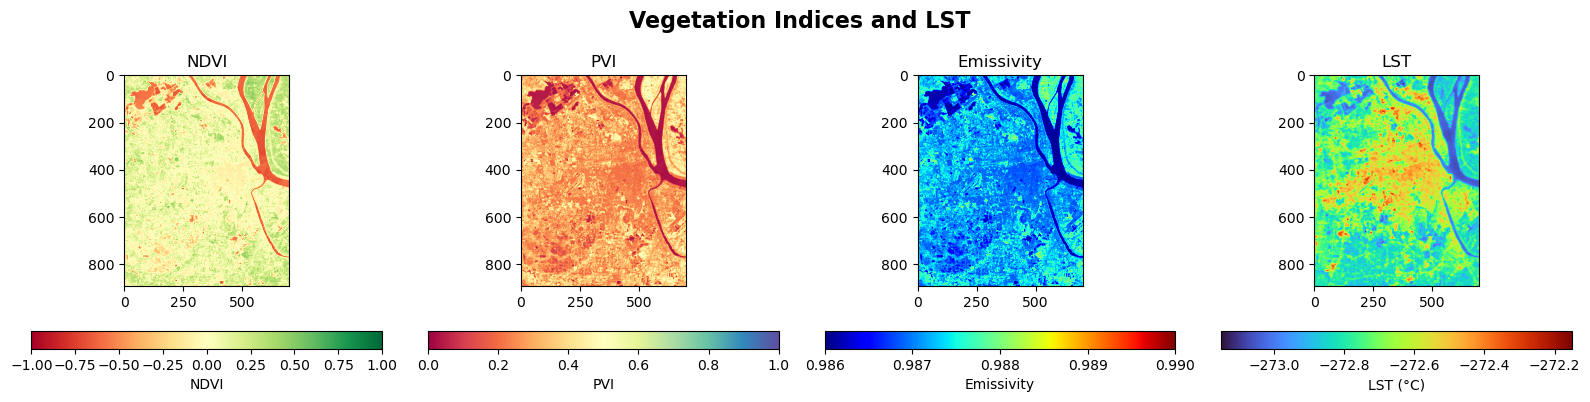

In [26]:
# Create a figure with subplots
fig, axs = mat_pyplt.subplots(1, 4, figsize=(16, 4))

# Plot NDVI
im0 = axs[0].imshow(ndvi, cmap='RdYlGn')
axs[0].set_title('NDVI')
fig.colorbar(im0, ax=axs[0], label='NDVI', orientation='horizontal')

# Plot PVI
im1 = axs[1].imshow(pvi, cmap='Spectral')
axs[1].set_title('PVI')
fig.colorbar(im1, ax=axs[1], label='PVI', orientation='horizontal')

# Plot Emissivity
im2 = axs[2].imshow(emissivity, cmap='jet')
axs[2].set_title('Emissivity')
fig.colorbar(im2, ax=axs[2], label='Emissivity', orientation='horizontal')

# Plot LST
im3 = axs[3].imshow(lst, cmap='turbo')
axs[3].set_title('LST')
fig.colorbar(im3, ax=axs[3], label='LST (°C)', orientation='horizontal')

# Add supertitle
fig.suptitle('Vegetation Indices and LST', fontsize=16, fontweight='bold')

# Adjust spacing between subplots
mat_pyplt.tight_layout()

# Save the figure
fig.savefig('./Data/Outputs/Indices.png')

# Show the plot
mat_pyplt.show()


In [27]:
# Define the output file path
lst_output_path = './Data/Outputs/lst.tif'

# Define the CRS and transformation parameters
crs = b4.crs
transform = b4.transform


# Write the ndvi_change array to a TIFF file with CRS, transform, and metadata
with rasterio.open(lst_output_path, 'w', driver='GTiff', height=lst.shape[0], width=lst.shape[1], count=1, dtype=lst.dtype, crs=crs, transform=transform, nodata=None) as dst:
    dst.write(lst, 1)



In [28]:
# # We are interested to calculate lst only for Phom Penh municipality. So lets clip the lst band

# # Rasterio expects the coordinates of the boundary points of mask layer in json format
# def getFeatures(gdf):
#     """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
#     import json
#     return [json.loads(gdf.to_json())['features'][0]['geometry']]

# boundary = getFeatures(phnom_penh_municipality_border)

# # Now clipping the raster
# from rasterio.mask import mask

# clipped_band, clipped_band_transform = mask(lst, shapes=boundary, crop=True)
# clipped_bands_data.append(clipped_band)
# clipped_bands_transforms.append(clipped_band_transform)